### Imports & Setup

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

In [ ]:
# Set up the dataset path
dataset_path = '.'

# Set up saving figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "InceptionResNetV2_Improved"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)  # create the sub-folders if they do not exist

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

print('> SETUP Done: all saved files are accessible in ', IMAGES_PATH)


# Setting all the parameters or hyperparameters
img_size = 128
test_size = 0.3
random_state = 42
validation_split = 0.2
epochs = 30
batch_size = 32
learning_rate = 0.0001

> SETUP Done: all saved files are accessible in  .\images\InceptionResNetV2_Improved


### Loading & preprocessing Data

In [6]:
# DATA LOADING & PREPROCESSING
def load_and_preprocess(img_size, test_size, random_state, date):
    print('> Loading data ...')
    data = np.load(f'{dataset_path}/twri_rgb_6832_cotton_{img_size}x{img_size}_{date}.npy')
    labels = pd.read_excel(f'{dataset_path}/labels_rgb.xlsx')
    print("Shape of data images:", data.shape)
    print(f"Shape of labeled data: {labels.shape[0]}:{labels.shape[1]}, header: {labels.columns}")
    y_label = labels['class'].values

    print('> Data and labels loaded')
    print('> Preprocessing Data: remove filler class + Split train/test + Normalization ...')

    # Adjusting size mismatch between data and labels
    min_length = min(data.shape[0], y_label.shape[0])
    data = data[:min_length]
    y_label = y_label[:min_length]

    # Remove filler class (class 0)
    valid_idx = y_label != 0
    data = data[valid_idx]
    y_label = y_label[valid_idx] - 1  # Adjust class index to start from 0

    # Define class names
    class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
    print('Concerned classes: ', class_names)

    # Split data into train and test sets
    train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=test_size, random_state=random_state)

    # Normalize images
    train_images, test_images = train_images / 255.0, test_images / 255.0

    print('> Data Preprocessing Done')
    return train_images, test_images, train_labels, test_labels, class_names

# Execute an example
date_ex = "8_18"
train_images, test_images, train_labels, test_labels, class_names = load_and_preprocess(img_size, test_size, random_state, date_ex)

> Loading data ...
Shape of data images: (6840, 128, 128, 3)
Shape of labeled data: 6832:3, header: Index(['FID', 'treatment', 'class'], dtype='object')
> Data and labels loaded
> Preprocessing Data: remove filler class + Split train/test + Normalization ...
Concerned classes:  ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']
> Data Preprocessing Done


### Build & Train the model
Use transfer learning to start from a pretrained inception model (InceptionResNetV2), but this time, we leave the last 50 layers to be re-trained over our dataset (not only the last custum Dense layers added) : fine-tuning

In [7]:
# MODEL BUILDING & TRAINING
def build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate):
    print('> Building the model ... ')

    # Build the model using InceptionResNetV2
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Fine-tune the model: Unfreeze the last few layers
    for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers
        layer.trainable = False

    # Add custom layers for classification
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x) # increase the nb neurons for more feature map capture
    x = Dropout(0.3)(x)
    output = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    print('> Training in progress ... ')
    # Train the model
    history = model.fit(train_images,
                        train_labels,
                        validation_split = validation_split,
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1)

    print('> End of Training !')
    return model, history

# Execute
model, history = build_and_train_model(img_size, train_images, train_labels, validation_split, epochs, batch_size, learning_rate)

> Building the model ... 

> Training in progress ... 
Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 727ms/step - accuracy: 0.3239 - loss: 1.4400 - val_accuracy: 0.4847 - val_loss: 1.1142
Epoch 2/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 809ms/step - accuracy: 0.5820 - loss: 0.9607 - val_accuracy: 0.6348 - val_loss: 0.8643
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 93s 923ms/step - accuracy: 0.7311 - loss: 0.6713 - val_accuracy: 0.6760 - val_loss: 0.7710
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 81s 855ms/step - accuracy: 0.8103 - loss: 0.4832 - val_accuracy: 0.7118 - val_loss: 0.7960
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 870ms/step - accuracy: 0.8827 - loss: 0.3087 - val_accuracy: 0.7078 - val_loss: 0.8857
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 889ms/step - accuracy: 0.9221 - loss: 0.2201 - val_accuracy: 0.6946 - val_loss: 1.0793
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 75s 783ms/step - accuracy: 0.9378 - loss: 0.1826 - val_accuracy: 0.6799 - val_loss: 1.1776
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 

### Evaluating the Model

> Evaluating the model ...
51/51 - 44s - 859ms/step - accuracy: 0.7068 - loss: 1.4127
Test Accuracy for 8_18: 0.71
51/51 ━━━━━━━━━━━━━━━━━━━━ 57s 917ms/step
Saving figure Confusion_matrix_8_18
                 precision    recall  f1-score   support

        rainfed       0.85      0.72      0.78       424
fully irrigated       0.82      0.77      0.80       399
percent deficit       0.59      0.60      0.60       404
     time delay       0.61      0.73      0.67       386

       accuracy                           0.71      1613
      macro avg       0.72      0.71      0.71      1613
   weighted avg       0.72      0.71      0.71      1613

Saving figure Training_Accuracy_8_18


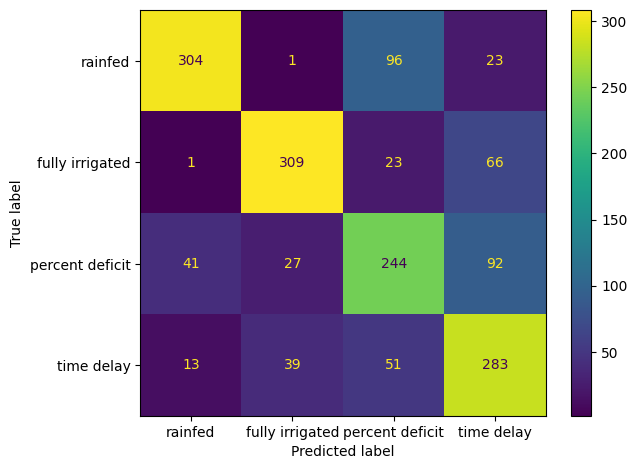

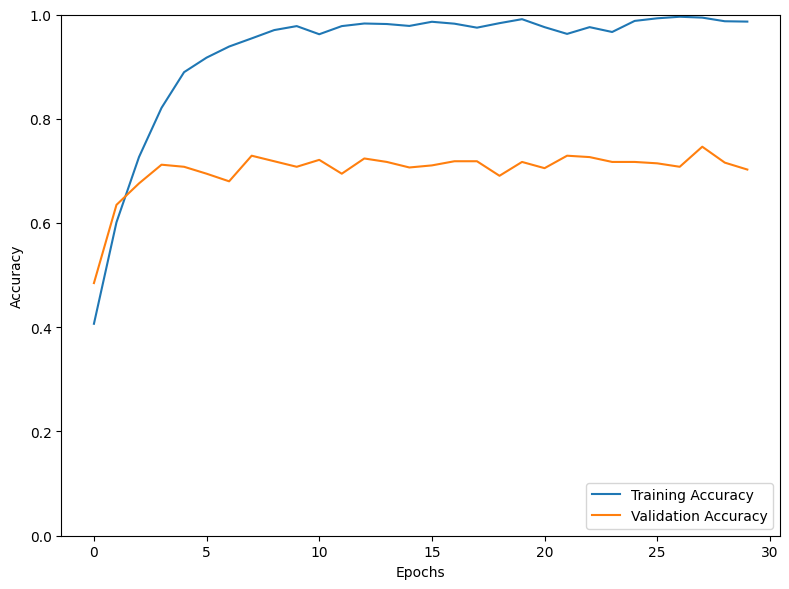

In [8]:
# MODEL EVALUATION
def evaluate_model(model, test_images, test_labels, date, history):
    print('> Evaluating the model ...')

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Test Accuracy for {date}: {test_acc:.2f}")

    # Predictions and classification report
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(test_labels, pred_classes, display_labels=class_names)
    save_fig(f"Confusion_matrix_{date}")

    # Classification report
    report = classification_report(test_labels, pred_classes, target_names=class_names)
    print(report)

    # Save the classification report
    report_path = f"{IMAGES_PATH}/Classification_Report_{date}.txt"
    with open(report_path, "w") as f:
        f.write(report)

    # Plot training history
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    save_fig(f"Training_Accuracy_{date}")

evaluate_model(model, test_images, test_labels, date_ex, history)
